In [1]:

import numpy as np
import time
import os
import sys
import copy
import torch
import torch.nn as nn
from datetime import datetime
from sklearn.metrics import confusion_matrix
list_pathstoadd = [
    "../../gpex/",
    "../../"
]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import skimage
from skimage import io
import gpex
import gpex.kernelmappings
from gpex.kernelmappings.image import Resnet50BackboneKernelDivideAvgPool

#import generalGPmodule
import skimage
from skimage import io
import resnetforminiimagenet
from resnetforminiimagenet import *
import loadminiimagenet
from loadminiimagenet import *

In [2]:
#settings ================
fname_gpexmodule_checkpoint = "NonGit/checkpoint_gpexmodule.pt"
#tune for each run ==
int_mode_modulekernel, num_backbones = 16, None
du_per_class = 20
rng_randw = [-1.0, 2.0]
mode_kernel = 16
if(True):
    flag_train_memefficient, memefficeint_heads_in_compgraph = False, None
dim_wideoutput = 1024
#tune for each dataset
batchsize = 10
#num_classes = 9
#general settings ===
idx_split = 0
int_exposedclass = None
flag_efficient = True
flag_detachcovpvn = True
flag_controlvariate = True
flag_setcovtoOne = False
int_mode_controlvariate = 2
val_clipgradient = None #set to None to avoid any gradient clipping.
fname_phase1output = None#"W0-1_relatively_fit/4872" #"model_0.96_outputwidth_1024"
mode_ann = 1 #int(sys.argv[1])


In [3]:
# #creaet path_output =====
# now = datetime.now()
# str_now = str_versionname + now.strftime("_%d-%m-%Y_%H-%M-%S")
# path_output = os.path.join(
#     "NonGit/Checkpoints/",
#     str_now
# )
# if(os.path.isdir(path_output) == False):
#     os.mkdir(path_output)
#     os.mkdir(os.path.join(path_output, "CheckpointAvoidNan/"))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
ds_train = loadminiimagenet.AkMinitImagenetDataset(
    rootdir_dataset = "NonGit/",
    str_trainortestorinducing = "train"
)
ds_recurring = loadminiimagenet.AkMinitImagenetDataset(
    rootdir_dataset = "NonGit/",
    str_trainortestorinducing = "inducing"
)
ds_test = loadminiimagenet.AkMinitImagenetDataset(
    rootdir_dataset = "NonGit/",
    str_trainortestorinducing = "test"
)
print("len(ds_train) = {}".format(len(ds_train)))
print("len(ds_recurring) = {}".format(len(ds_recurring)))
print("len(ds_test) = {}".format(len(ds_test)))
assert(set(ds_train.Y) == set(ds_test.Y))
num_classes = len(list(set(ds_train.Y)))
print("num_classes was set to {}".format(num_classes))

len(ds_train) = 38400
len(ds_recurring) = 38400
len(ds_test) = 19200
num_classes was set to 64


In [6]:

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batchsize,
                      shuffle=True, num_workers=2)
dl_recurring = torch.utils.data.DataLoader(ds_recurring, batch_size=batchsize,
                          shuffle=False, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batchsize,
                     shuffle=False, num_workers=4)

In [7]:
class ClampAndTanh(torch.nn.Module):
    def __init_(self, minval=-1.0, maxval=1.0):
        self.minval, self.maxval = minval, maxval
        super(ClampAndTanh, self).__init__()
        
        
    def forward(self, x):
        output = torch.nn.functional.tanh(
                        torch.clamp(
                            x, -1.0, 1.0
                        )
                    )
        return output
    
def initweights_to_zero(m):
    if type(m) in {nn.Linear, nn.Conv2d, nn.Linear}:
        torch.nn.init.zeros_(m.weight)
        m.bias.data.fill_(np.random.randn()*0.1) #TODO:check
    
class ModuleF1(torch.nn.Module):
    def __init__(self, module_caller):
        super(ModuleF1, self).__init__()
        #make internals ===
        self.module = Resnet50BackboneKernelDivideAvgPool(
                num_classes = num_classes,
                du_per_class = du_per_class
        )
        print("<><><><><><><><><> finisehd creating module_tail <><><><><><><><>.")
    
    def set_rng_outputheads(self, rng_outputhead):
        self.module.set_rng_outputheads(rng_outputhead)
    
    
    def forward(self, x):
        toret = self.module(x)
        toret = toret.unsqueeze(-1).unsqueeze(-1)
        return toret

In [8]:
class MainModule(nn.Module):
    def __init__(self, num_classes, device, dl_recurring, dl_nonrecurring, dl_test, batchsize, dim_wideoutput):
        '''
        Inputs:
            - size_input: size of the input, e.g., [32 x 2000 x 7 x 7].
            - device: the device on which the GP fields are going to be created.
            - num_outputheads: an integer, number of output heads.
        '''
        super(MainModule, self).__init__()
        #grab args ===
        self.num_classes = num_classes
        self.device = device
        self.dl_recurring = dl_recurring
        self.dl_nonrecurring = dl_nonrecurring
        self.dl_test = dl_test
        self.batchsize = batchsize
        #self.iter_dl_recurring = iter(self.dl_recurring)
        #make internal module_tobecomeGP ===
        self.module_tobecomeGP = AkResNet18(
            num_classes=num_classes,
            dim_wideoutput=dim_wideoutput
        )
        #make internals ===
        self.dic_dlname_to_iter = {
            "dl_recurring":iter(self.dl_recurring),
            "dl_nonrecurring":iter(self.dl_nonrecurring),
            "dl_test":iter(self.dl_test)
        }
        #make module f1 ===
        self.module_f1 = ModuleF1(self) #nn.Sequential(
        self._lastidx_recurring = []
        #internal field to subsample when feeding minbatch ====
        self.n_subsampleminibatch = None
            
    def forward(self, x, y, n):
        return self.module_tobecomeGP(x), y, n
        
    
    def func_get_modulef1(self):
        return self.module_f1
    
    def func_mainmodule_to_moduletobecomeGP(self, module_input):
        return module_input.module_tobecomeGP
    
    
    def _func_feed_minibatch(self, dl_input, str_dlname, flag_addnoisetoX = False):
        #print("reached here 1")
        if(False):#iter_dl is None):
            pass #x, y, n = next(iter(dl_input))
        else:
            try:
                x, y, n = next(self.dic_dlname_to_iter[str_dlname])
            except (StopIteration):
                self.dic_dlname_to_iter[str_dlname] = iter(dl_input)
                x, y, n = next(self.dic_dlname_to_iter[str_dlname])
                
        
        if(flag_addnoisetoX == True):
            idx_permutex = np.random.permutation([u for u in range(list(x.size())[0])]).tolist()
            idx_permutex = torch.LongTensor(idx_permutex)
            x_perumted = x[idx_permutex, :, :, :]
            
            rand_w = torch.rand((list(x.size())[0])).float().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) #[Nx1x1x1]
            rand_w = rand_w*(rng_randw[1]-rng_randw[0]) + rng_randw[0] #in [rng[0] , rng[1]]
            rand_w = rand_w.detach()
            #print("rand_w.shape = {}".format(rand_w.shape))
            x = rand_w*x + (1.0-rand_w)*x_perumted  #[N x 3 x 224 x 224]
            x = x + 0.1*torch.randn_like(x).float()
        
        #print("reached here 2")
#         if(dl_input.dataset == ds_recurring):
#             self._lastidx_recurring = n #TODO:move this operation inside the dl.
        #print("reached here 3")
        #print("x.shape = {}".format(x.shape))
        #print("y.shape = {}".format(y.shape))
        
        if(self.n_subsampleminibatch is None):
            pass
        else:
            x = x[0:self.n_subsampleminibatch, :,:,:]
            y = y[0:self.n_subsampleminibatch]
            n = n[0:self.n_subsampleminibatch]
        
        if(dl_input.dataset == ds_recurring):
            self._lastidx_recurring = n
            if(len(n) != list(x.size())[0]):
                assert False
        
        output, _, _ = self.forward(x.to(self.device), y, n)
        
        #print("reached here 4")
        return output, y, n
    
    def func_feed_recurring_minibatch(self):
        output, y, n = self._func_feed_minibatch(
                            self.dl_recurring,
                            str_dlname = "dl_recurring"
                         )
        return output, y, n
    
    def func_feed_noise_minibatch(self):
        output, y, n = self._func_feed_minibatch(
                        self.dl_nonrecurring,
                        str_dlname = "dl_nonrecurring",
                        flag_addnoisetoX=True
                      )
        return output, y, n
    
    def func_feed_nonrecurring_minibatch(self):
        output, y, n = self._func_feed_minibatch(
                                self.dl_nonrecurring,
                                str_dlname = "dl_nonrecurring",
                                flag_addnoisetoX=False
                              )
        return output, y, n
    
    def func_feed_test_minibatch(self):
        output, y, n = self._func_feed_minibatch(
                                    self.dl_test,
                                    str_dlname = "dl_test"
                                )
        self._last_idx_test = n.tolist()
        return output, y, n
    
    def func_get_indices_lastrecurringinstances(self):
        return self._lastidx_recurring.cpu().numpy().tolist()
    
    def func_get_idxlastfed_testdl(self):
        return self._last_idx_test

In [9]:
model = MainModule(
    dim_wideoutput=dim_wideoutput,
    num_classes = num_classes,
    device = device,
    dl_recurring = dl_recurring,
    dl_nonrecurring = dl_train,
    dl_test = dl_test,
    batchsize = batchsize
  )

>>>>>>> self.dim_wideoutput = 1024
C_head is equal to 2048.
<><><><><><><><><> finisehd creating module_tail <><><><><><><><>.


In [10]:
model.to(device)
#model.n_subsampleminibatch = 50
gpmodel = gpex.GPEXModule(
    module_rawmodule = model,
    size_recurringdataset = len(ds_recurring),
    device = device,
    func_mainmodule_to_moduletobecomeGP = model.func_mainmodule_to_moduletobecomeGP, 
    func_feed_noise_minibatch = model.func_feed_noise_minibatch,
    func_feed_inducing_minibatch = model.func_feed_recurring_minibatch,
    func_feed_nonrecurring_minibatch = model.func_feed_nonrecurring_minibatch,
    func_feed_test_minibatch = model.func_feed_test_minibatch,
    func_get_indices_lastrecurringinstances = model.func_get_indices_lastrecurringinstances,
    func_get_modulef1 = model.func_get_modulef1,
    flag_efficient = flag_efficient,
    flag_detachcovpvn = flag_detachcovpvn,
    flag_controlvariate = flag_controlvariate,
    flag_setcovtoOne = flag_setcovtoOne,
    int_mode_controlvariate = int_mode_controlvariate,
    flag_train_memefficient = flag_train_memefficient,
    memefficeint_heads_in_compgraph = memefficeint_heads_in_compgraph
  )
#model.n_subsampleminibatch = 50
gpmodel.sigma2_GP = 1.0 #TODO:check
gpmodel.train()
gpmodel.to(device)
print("gpmodel was created on {}".format(device))

Controlvariate mode is set to 2
x.shape = torch.Size([10, 3, 84, 84])
    Dv was set to 64
gpmodel was created on cuda:0


In [11]:
#load model from checkpoint ====
gpmodel.load_state_dict(
    torch.load(
        fname_gpexmodule_checkpoint
    ),
    strict = True
)
gpmodel.eval()
gpmodel.to(device)
print("gpmodel was loaded from {}".format(fname_gpexmodule_checkpoint))

gpmodel was loaded from NonGit/checkpoint_gpexmodule.pt


a-b in range [-17.13520622253418 , 11.764018058776855]


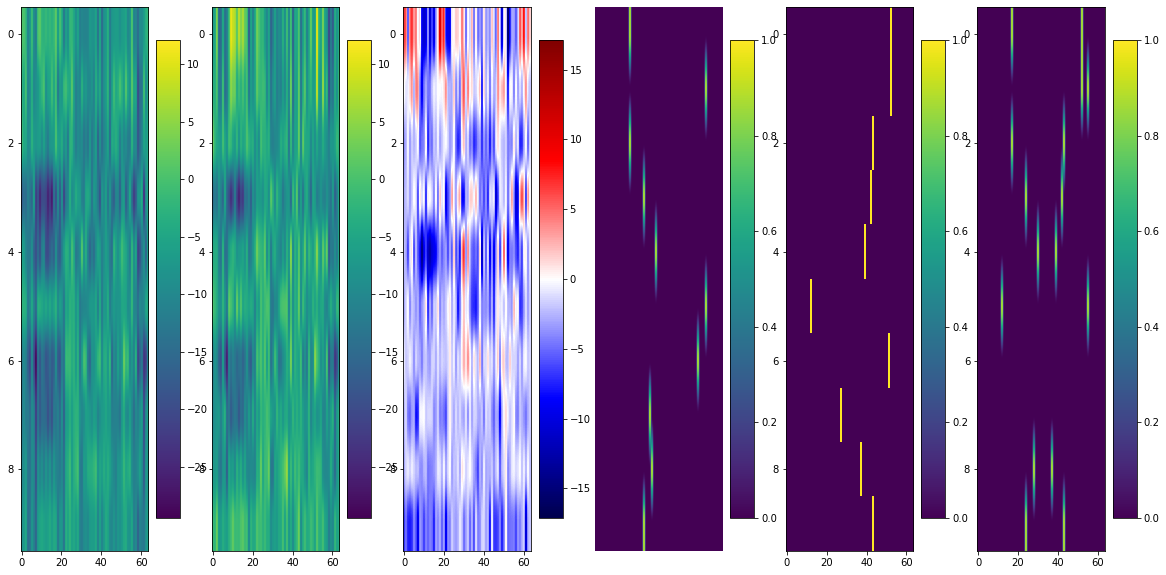

a-b in range [-25.36695098876953 , 9.316287994384766]


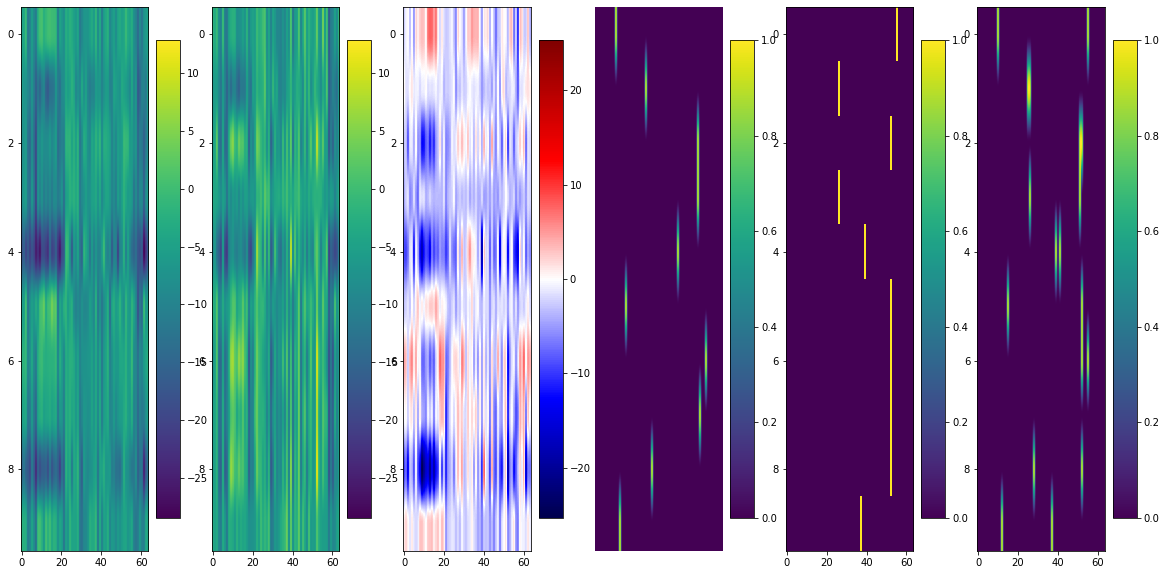

a-b in range [-17.3279972076416 , 7.279195785522461]


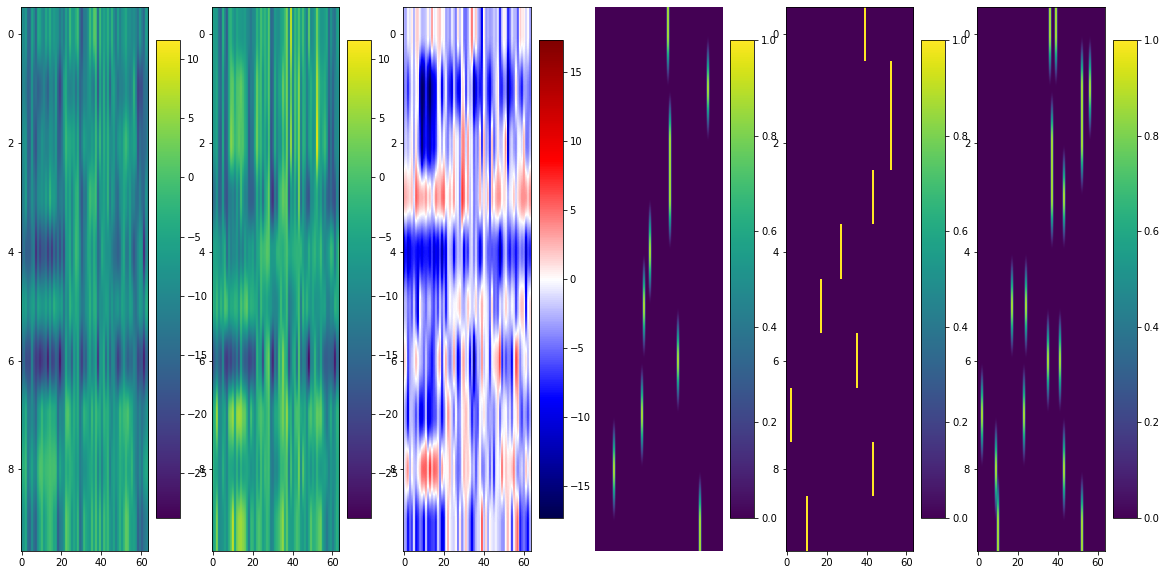

a-b in range [-23.846803665161133 , 6.815837860107422]


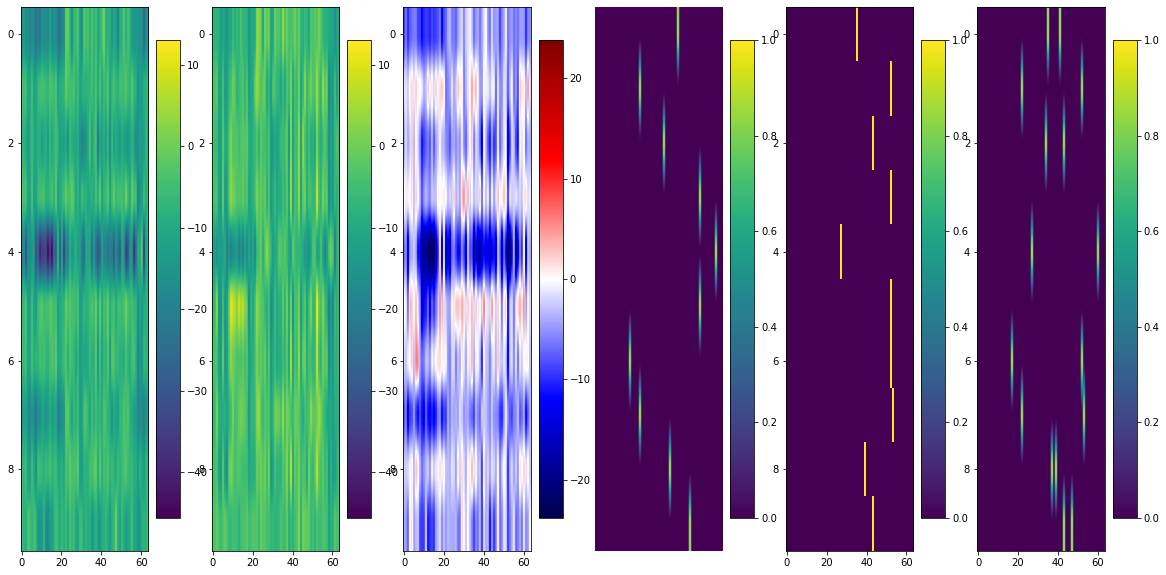

a-b in range [-24.92232894897461 , 8.516483306884766]


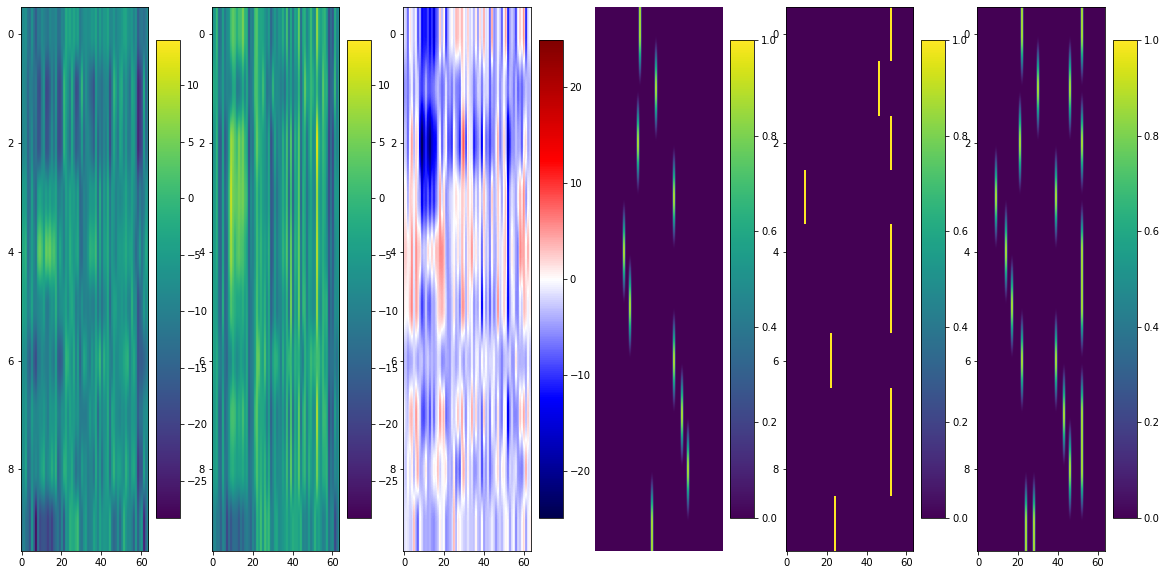

a-b in range [-22.474517822265625 , 17.61224365234375]


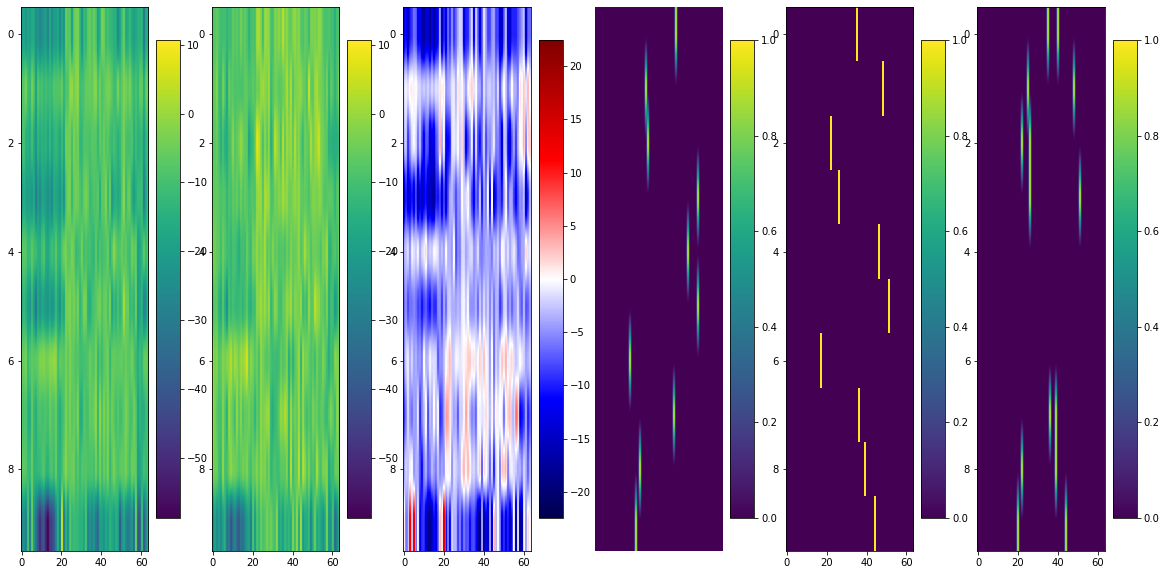

a-b in range [-17.26982307434082 , 8.219120979309082]


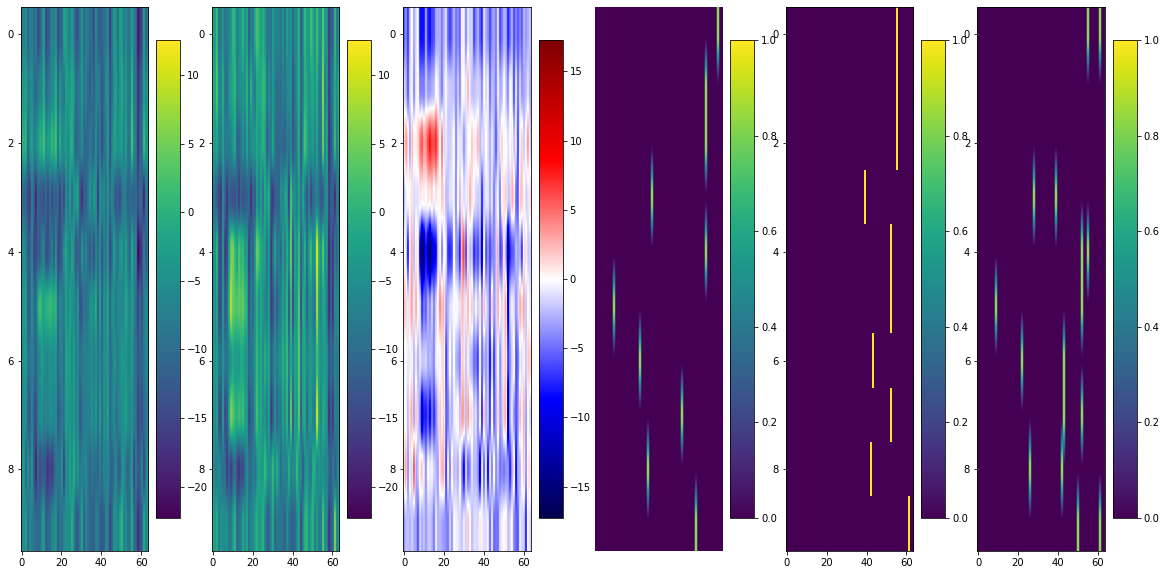

a-b in range [-19.410076141357422 , 5.820021629333496]


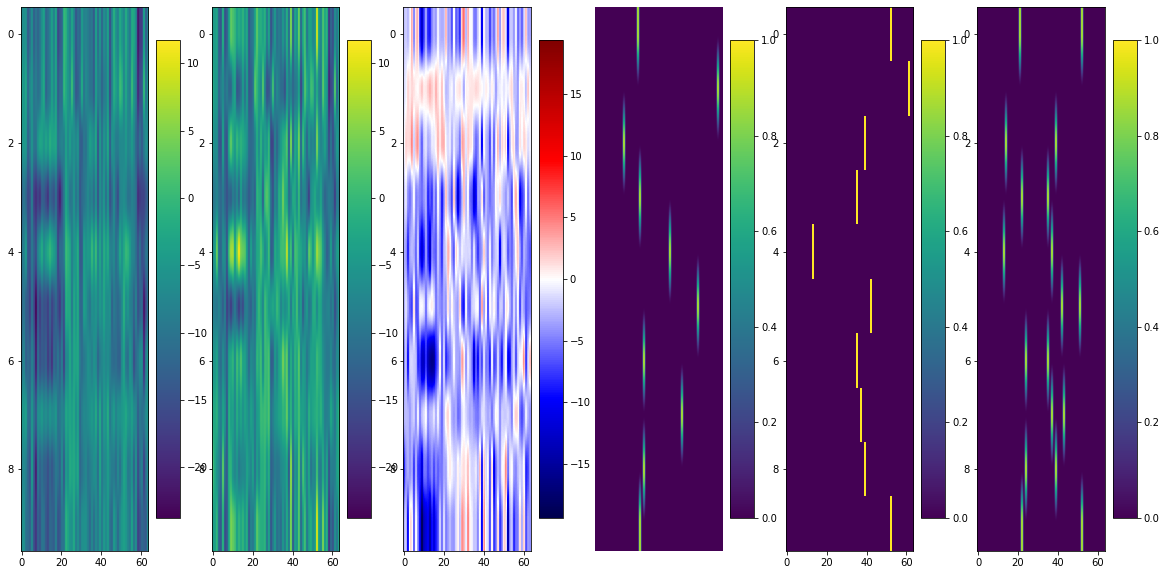

a-b in range [-18.44734001159668 , 14.199634552001953]


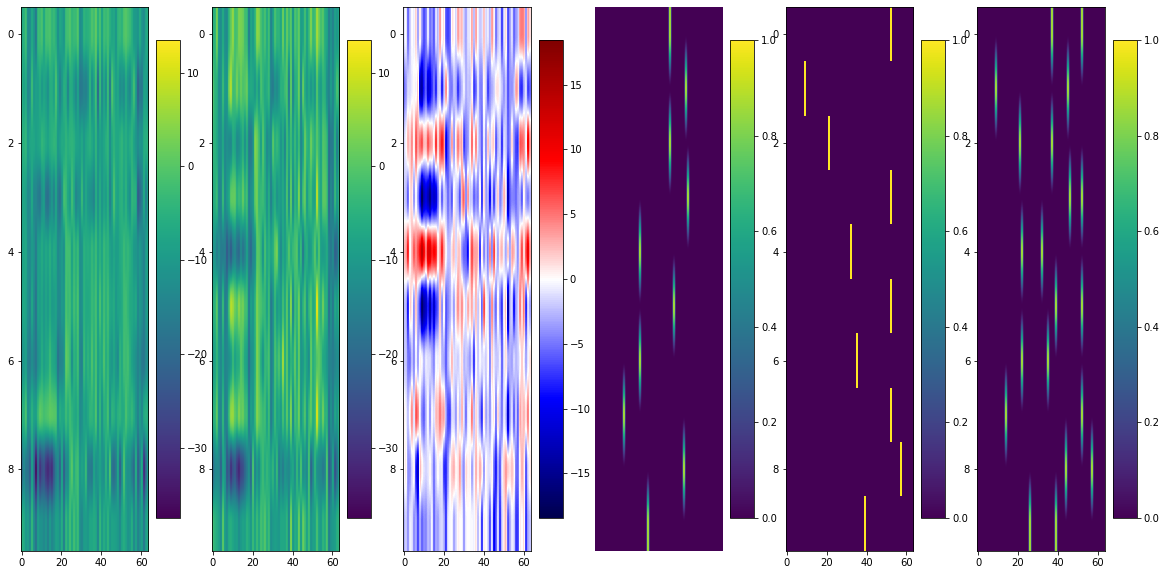

a-b in range [-20.63109588623047 , 6.177085876464844]


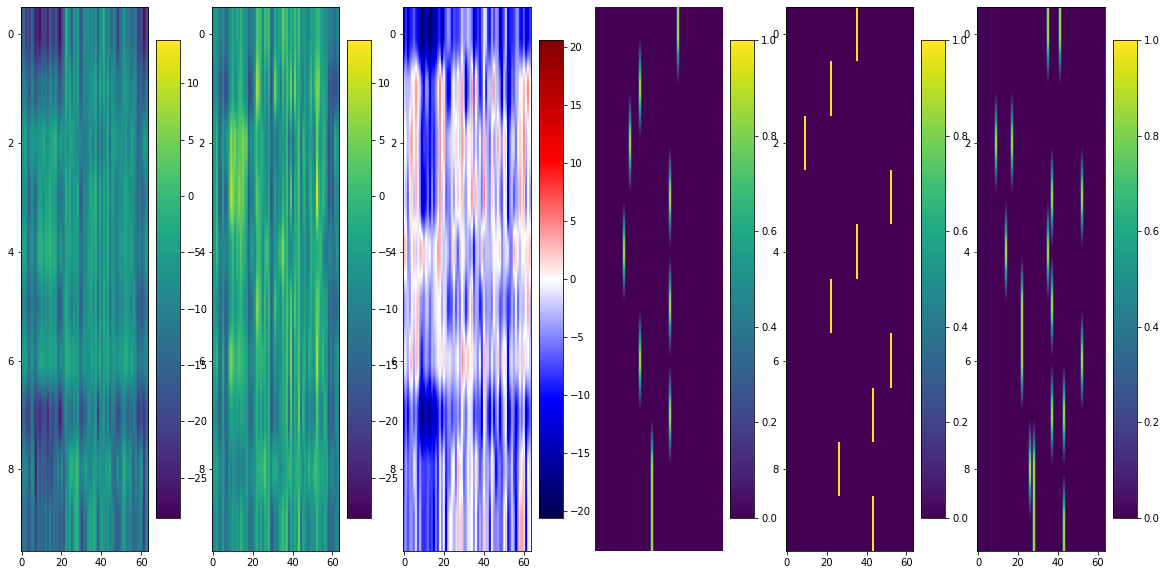

In [12]:
FLAG_RELU = False
gpmodel.eval()
list_outputgpoutputg = gpmodel.checkequal_f1path_gpath_ontest(10)
gpmodel.train()
for n in range(len(list_outputgpoutputg)):
    a = list_outputgpoutputg[n][0]
    b = list_outputgpoutputg[n][1]
    if(FLAG_RELU == True):
        a = np_relu(a); b = np_relu(b)
    
    min_ab = min(np.min(a), np.min(b))
    max_ab = max(np.max(a), np.max(b))
    print("a-b in range [{} , {}]".format(np.min(a-b), np.max(a-b)))
    #print(np.round(a[0:5, 0:5], 2))
    #print(np.round(b[0:5, 0:5], 2))
    
    #compute the class activations ====
    gpmodel.eval()
    with torch.no_grad():
        if(int_exposedclass is None):
            try:
                classactivation_a = gpmodel.module_rawmodule.linear(torch.tensor(a).float().to(device))
                classactivation_b = gpmodel.module_rawmodule.linear(torch.tensor(b).float().to(device))
                classactivation_a = classactivation_a.detach().cpu().numpy()
                classactivation_b = classactivation_b.detach().cpu().numpy()
                onehot_a = np.zeros((batchsize, num_classes))
                onehot_a[list(range(batchsize)), np.argmax(classactivation_a, 1).tolist()] = 1
                onehot_b = np.zeros((batchsize, num_classes))
                onehot_b[list(range(batchsize)), np.argmax(classactivation_b, 1).tolist()] = 1

                min_classactivations = min(np.min(classactivation_a), np.min(classactivation_b))
                max_classactivations = max(np.max(classactivation_a), np.max(classactivation_b))
            except:
                onehot_a = np.zeros((batchsize, num_classes))
                onehot_a[list(range(batchsize)), np.argmax(a, 1).tolist()] = 1
                onehot_b = np.zeros((batchsize, num_classes))
                onehot_b[list(range(batchsize)), np.argmax(b, 1).tolist()] = 1
    gpmodel.train()
    
    if(int_exposedclass is None):
        plt.figure(figsize=(20,10))
        plt.subplot(1,6,1)
        plt.imshow(np.round(a, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
        plt.subplot(1,6,2)
        plt.imshow(np.round(b, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
        plt.subplot(1,6,3)
        plt.imshow(np.round(a-b, 2), cmap="seismic", vmin=-np.max(np.abs(a-b)),\
                   vmax=np.max(np.abs(a-b)), aspect="auto"); plt.colorbar()
        plt.subplot(1,6,4)
        plt.imshow(onehot_a, vmin=0,
                   vmax=1, aspect="auto")
        plt.axis("off")
        plt.colorbar()
        plt.subplot(1,6,5)
        plt.imshow(onehot_b, vmin=0,
                   vmax=1, aspect="auto")
        plt.colorbar()
        plt.subplot(1,6,6)
        plt.imshow(np.abs(onehot_b - onehot_a), aspect="auto")
        plt.colorbar()
        plt.show()        
    else:
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(np.expand_dims(np.round(a, 2), -1), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
        plt.subplot(1,2,2)
        plt.imshow(np.expand_dims(np.round(b, 2), -1), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
        plt.show()

Plot the scatters and compute the correlation coefficients.

In [13]:
def GPdiffANN_ontorchdl(gpmodel, dl_input, input_device):
    '''
    Comptues the difference between a GP and ANN on a torch dataloader.
    '''
    gpmodel.eval()
    set_seen = set([])
    dict_n_to_diff = {
        n:None for n in range(len(dl_input))
    }
    dict_n_to_gt = {
        n:None for n in range(len(dl_input))
    }
    for idx, data in enumerate(dl_input):
        print("Visited {} instances out of {}.".format(
                len(set_seen), len(dl_input.dataset)
                ),
              end='\r'
        )
        #compute GPdiffANN on the minibatch
        x, y, n = data
        with torch.no_grad():
            #feed to gp ====
            gp_output, _, _ = gpmodel.testingtime_forward(
                            x.to(input_device), y, n
            )
            gp_output = gp_output[0].detach().cpu().numpy()[:,:,0,0]
            #feed to ann ===
            ann_output = gpmodel.module_tobecomeGP(x.to(input_device)) #[N x Dv]
            ann_output = ann_output.detach().cpu().numpy() #[N x Dv]
        
        #grab results ====
        gp_cat_ann = np.concatenate([gp_output, ann_output], 1)
        n = n.tolist()
        y = y.tolist()
        set_seen = set_seen.union(set(n))
        for local_j, global_j in enumerate(n):
            dict_n_to_diff[global_j] = gp_cat_ann[local_j, :]
            dict_n_to_gt[global_j] = y[local_j]
    gpmodel.train()
    return dict_n_to_diff, dict_n_to_gt

In [16]:
import gpex.evaluation
#from gpex.evaluation import GPdiffANN_ontorchdl
from sklearn.metrics import cohen_kappa_score
from scipy import stats

dict_idx_to_gpout, dict_idx_to_annout = gpmodel.check_GPmatchANN_on_aDataloader(
    func_feed_dlinstances = model.func_feed_test_minibatch,
    func_get_lastidx_fedinstances = model.func_get_idxlastfed_testdl,
    list_allidx = [n for n in range(len(ds_test))]
)

In [21]:
np_gpann = \
 np.array([dict_idx_to_gpout[k]+dict_idx_to_annout[k] for k in dict_idx_to_annout.keys()])
numclasses = int(np_gpann.shape[1]/2)
list_correlation = []
for c in range(numclasses):
    list_correlation.append(
        stats.pearsonr(np_gpann[:, c], np_gpann[:, c+numclasses])[0]
    )

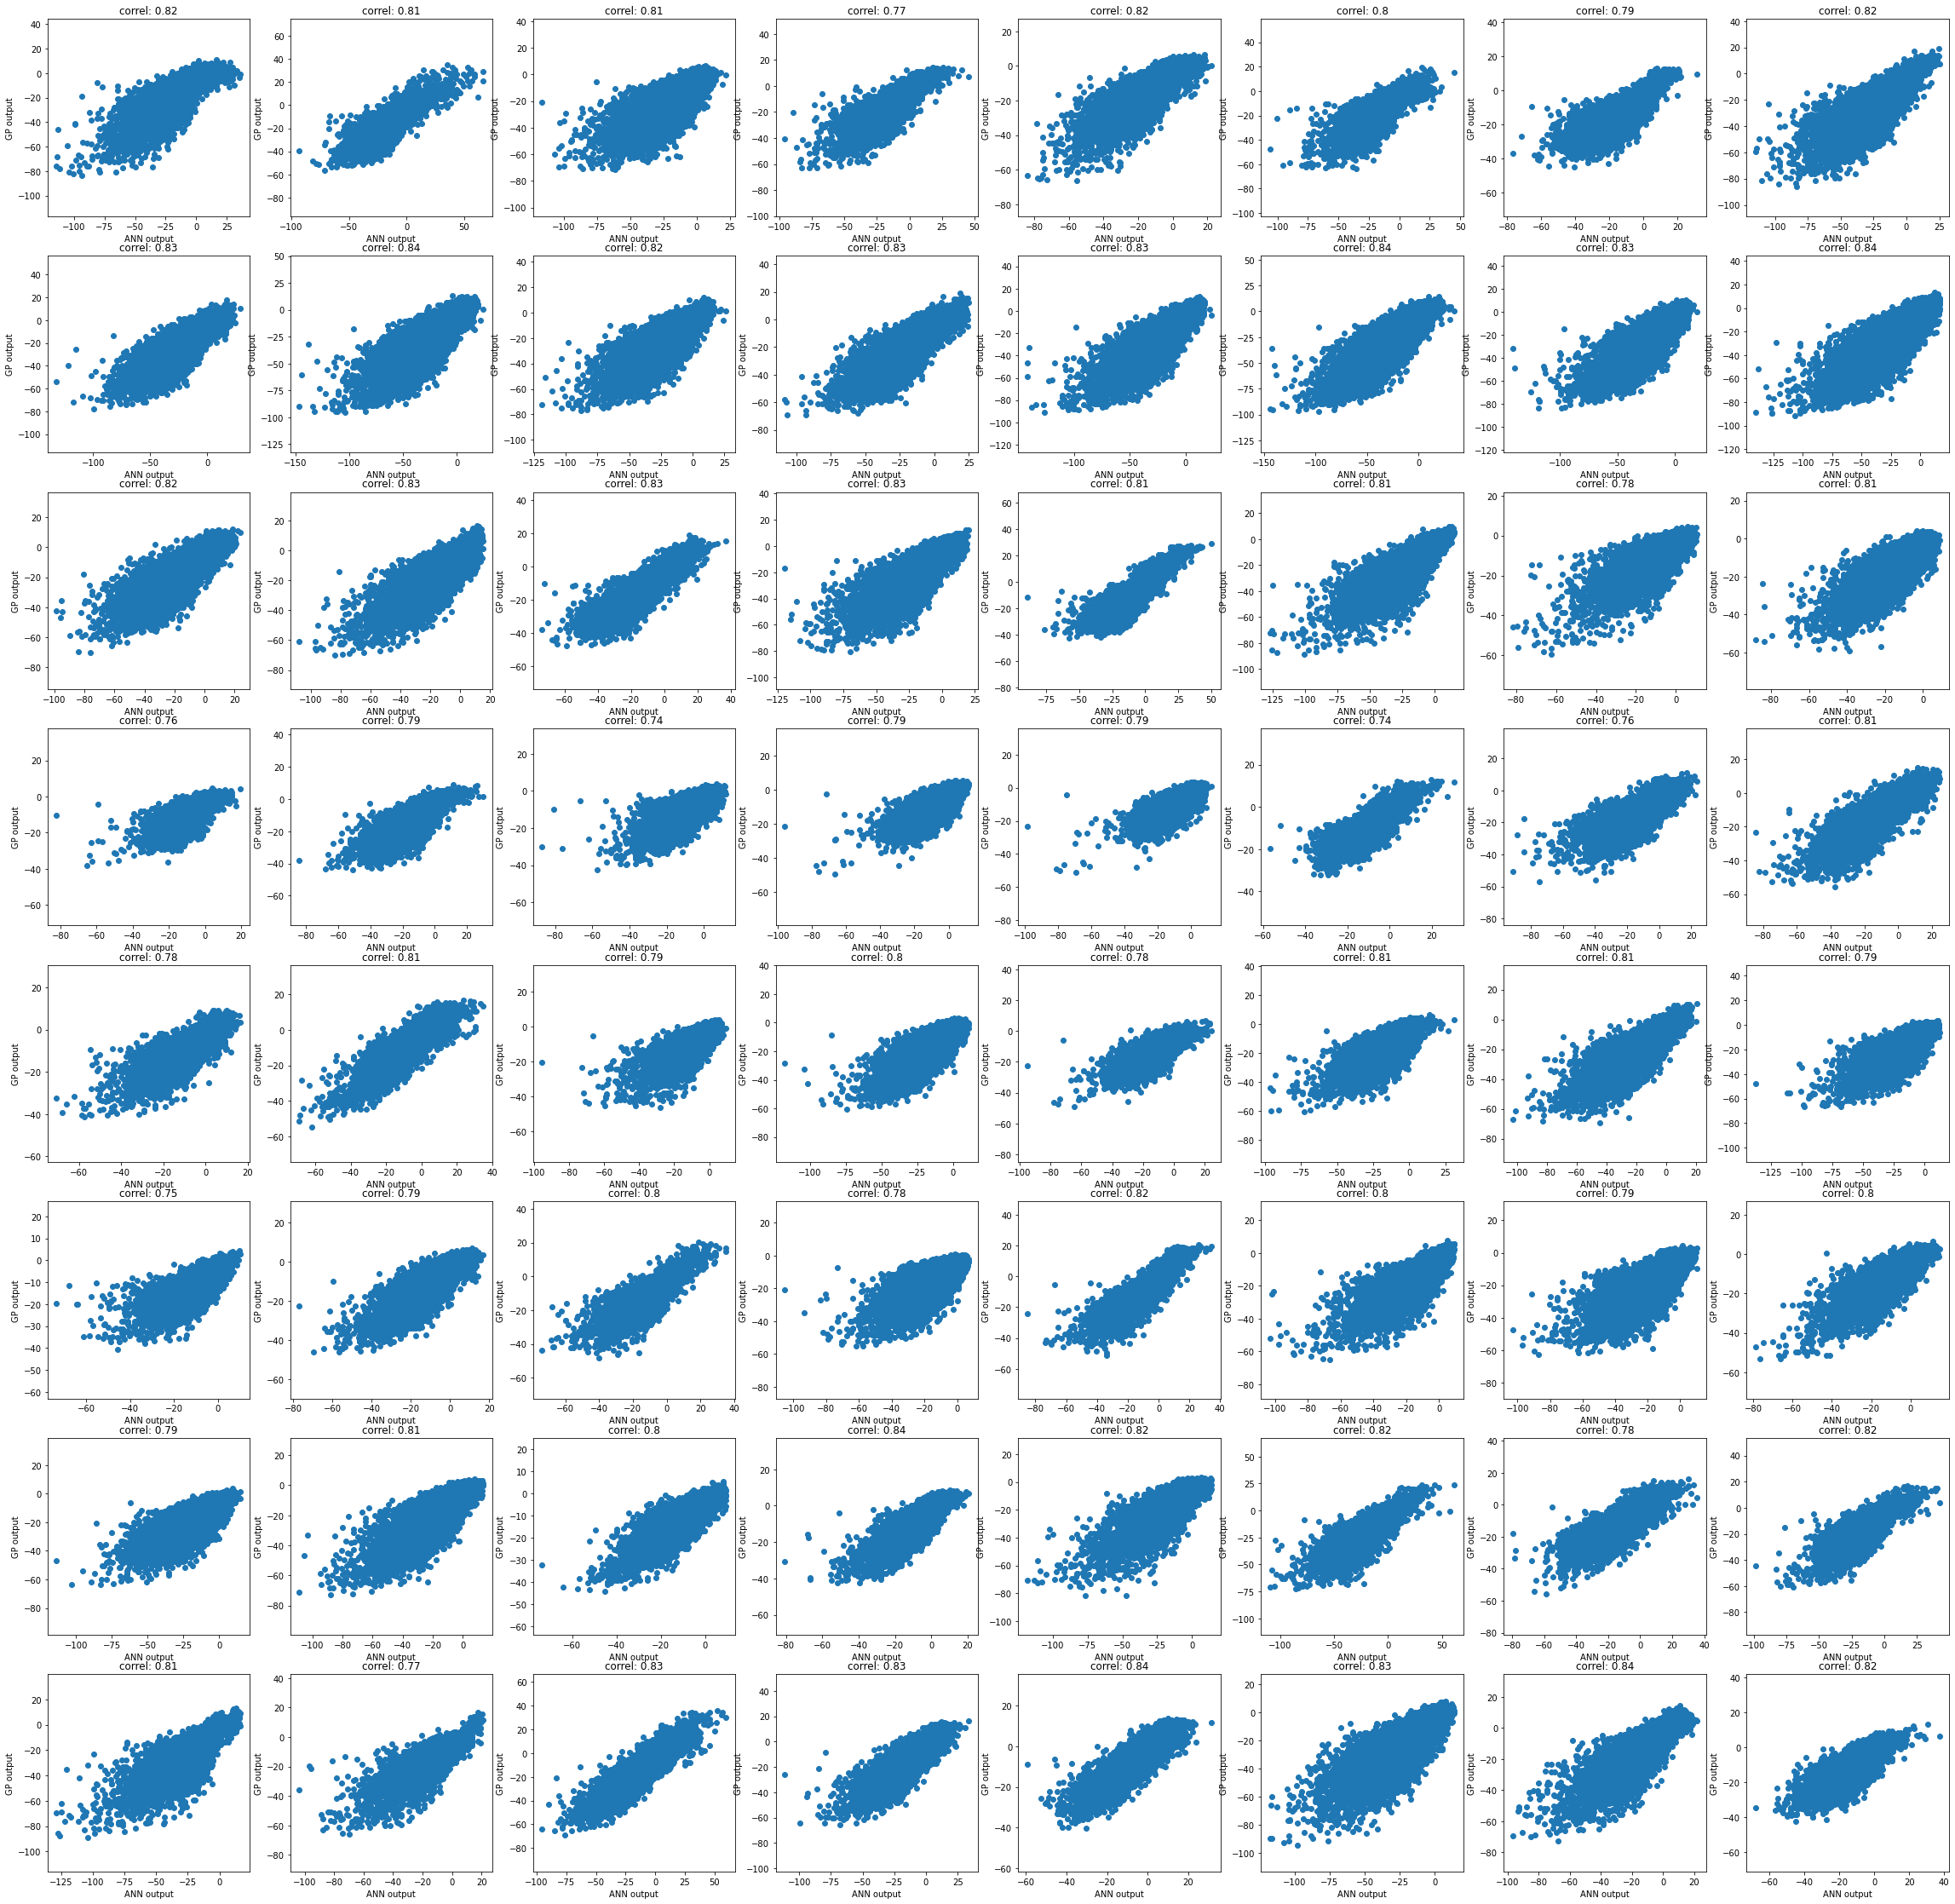

In [22]:
#plot all scatters ===
np_gp = np_gpann[:,0:64]
np_ann = np_gpann[:, 64::]
plt.figure(figsize=[40,40])
cnt_plotted = 1
for k in range(64):
    plt.subplot(8,8,k+1)
    plt.scatter(np_ann[:,k], np_gp[:,k])
    plt.title("correl: {}".format(np.round(list_correlation[k], 2)))
    plt.axis('equal')
    plt.xlabel("ANN output")
    plt.ylabel("GP output")
plt.show()